In [42]:
import Pkg
Pkg.activate(".")

pkgs = [
"Revise",
"DataFrames",
"ProgressMeter",
"Statistics",
"uCSV",
"StatsBase",
"StatsPlots"
]
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

import Mycelia

  Activating environment at `/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/notebooks/Project.toml`
   Resolving package versions...
  No Changes to `/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/notebooks/Project.toml`
  No Changes to `/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/notebooks/Manifest.toml`
Precompiling project...
  ✓ Mycelia
  1 dependency successfully precompiled in 23 seconds (248 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [2]:
# get all taxonids at or below virus
# mamba create -n taxonkit -c bioconda taxonkit
# wget -c ftp://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz 
# tar -zxvf taxdump.tar.gz
# mkdir -p $HOME/.taxonkit
# cp names.dmp nodes.dmp delnodes.dmp merged.dmp $HOME/.taxonkit
# --data-dir

viral_tax_ids = Set(parse.(Int, filter(!isempty, readlines(`mamba run -n taxonkit taxonkit list --ids 10239 --indent ""`))))

Set{Int64} with 239372 elements:
  2956278
  656260
  1742422
  1427858
  2783550
  1599415
  300190
  2901373
  468417
  864692
  1149619
  2798297
  2946055
  2764961
  2827923
  1431632
  1733762
  1924399
  1613832
  2558856
  2822896
  1686811
  438298
  438823
  1347503
  ⋮ 

In [3]:
n_methods = 8

8

In [4]:
# uniref_dbs = [
#     "UniRef100",
#     "UniRef90",
#     "UniRef50"
# ]
data_dir = joinpath(dirname(pwd()), "data")
SRR_paths = filter(x -> !occursin(".ipynb_checkpoints", x), readdir(joinpath(data_dir, "SRA"), join=true))

594-element Vector{String}:
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399460"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399461"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399462"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399463"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399464"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399465"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399466"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399467"
 "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/dat

In [12]:
?nonmissingtype

search: nonmissingtype



```
nonmissingtype(T::Type)
```

If `T` is a union of types containing `Missing`, return a new type with `Missing` removed.

# Examples

```jldoctest
julia> nonmissingtype(Union{Int64,Missing})
Int64

julia> nonmissingtype(Any)
Any
```

!!! compat "Julia 1.3"
    This function is exported as of Julia 1.3.



In [31]:
sample_summary_table = DataFrames.DataFrame(
    sample_id = String[],
    total_mapped_bases = Int[],
    total_contigs = Int[],
    total_assembly_size = Int[],
    percent_contigs_viral = Float64[],
    percent_mapped_bases_viral = Float64[]
)

ProgressMeter.@showprogress for SRR_path in SRR_paths

    contig_info_pattern = basename(SRR_path) * ".final.contigs.fastg.gfa.fna"
    contig_info_files = filter(x -> occursin(contig_info_pattern, x), readdir(SRR_path, join=true))
    joint_contig_info_table = DataFrames.DataFrame()
    for f in contig_info_files
        table_col_types = [
            Int64,
            Int64,
            Int64,
            Float64,
            Float64,
            Float64,
            String,
            String,
            String,
            Int64,
            String,
            Float64,
            Float64,
            Float64,
            Float64,
            Int64,
            Int64,
            Int64,
            Int64,
            Int64,
            Int64,
            Int64,
            Int64,
            Int64,
        ]
        method = replace(replace(basename(f), basename(SRR_path) * ".final.contigs.fastg.gfa.fna." => ""), ".contig_info.tsv" => "")
        this_contig_info_table = DataFrames.DataFrame(uCSV.read(f, delim='\t', header=1, types=table_col_types, encodings=Dict("" => missing), allowmissing=true)...)
        this_contig_info_table[!, "Method"] .= method
        this_contig_info_table[!, "SRR"] .= basename(SRR_path)
        append!(joint_contig_info_table, this_contig_info_table)
    end
    sort!(joint_contig_info_table, "Contig")
    contig_info_table = unique(joint_contig_info_table[!, ["SRR", "Contig", "Length", "Mapped bases", "Mean coverage", "Standard Deviation", "% Mapped bases"]])

    blast_classifications_table = joint_contig_info_table[.!ismissing.(joint_contig_info_table[!, "subject id"]), DataFrames.Not(names(contig_info_table[!, DataFrames.Not("Contig")]))]
    sort!(blast_classifications_table, ["Contig", "evalue"])
    blast_hits_top_hits_table = DataFrames.combine(DataFrames.groupby(blast_classifications_table, ["Contig", "Method"]), first)
    blast_hits_top_hits_table = blast_hits_top_hits_table[map(x -> x in viral_tax_ids, blast_hits_top_hits_table[!, "subject tax id"]), :]

    joint_lca_table = DataFrames.DataFrame()
    easy_taxonomy_lca_reports = filter(x -> occursin("final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.", x) && occursin("_lca.tsv", x), readdir(joinpath(SRR_path, "mmseqs_easy_taxonomy"), join=true))
    for lca_tsv in easy_taxonomy_lca_reports
        method = replace(replace(basename(lca_tsv), "final.contigs.fastg.gfa.fna." => ""), "_lca.tsv" => "")
        this_lca_table = Mycelia.parse_mmseqs_easy_taxonomy_lca_tsv(lca_tsv)
        this_lca_table[!, "SRR"] .= basename(SRR_path)
        this_lca_table[!, "SRR"] .= method
        append!(joint_lca_table, this_lca_table)
    end
    sort!(joint_lca_table, "contig_id")
    joint_lca_table = joint_lca_table[map(x -> x in viral_tax_ids, joint_lca_table[!, "taxon_id"]), :]

    virsorter_score_tsv = joinpath(SRR_path, "virsorter", "final-viral-score.tsv")
    virsorter_results = Mycelia.parse_virsorter_score_tsv(virsorter_score_tsv)
    virsorter_results[!, "seqname"] = parse.(Int, first.(split.(virsorter_results[!, "seqname"], '|')))
    # virsorter_results

    genomad_virus_summary = joinpath(SRR_path, "genomad", "final.contigs.fastg.gfa_summary", "final.contigs.fastg.gfa_virus_summary.tsv")
    genomad_results = DataFrames.DataFrame(uCSV.read(genomad_virus_summary, delim='\t', header=1, typedetectrows=100)...)

    number_of_hits = vcat(
        blast_hits_top_hits_table[!, "Contig"],
        joint_lca_table[!, "contig_id"],
        virsorter_results[!, "seqname"],
        genomad_results[!, "seq_name"]
    )

    contig_support_counts = StatsBase.countmap(number_of_hits)

    contig_info_table[!, "viral_classification_count"] = map(contig -> get(contig_support_counts, contig, 0), contig_info_table[!, "Contig"])

    contig_info_table[!, "viral_classification_percent"] = round.((contig_info_table[!, "viral_classification_count"] ./ n_methods) .* 100, digits=1)
    contig_info_table

    sample_summary_row = (
        sample_id = contig_info_table[1, "SRR"],
        total_mapped_bases = sum(contig_info_table[!, "Mapped bases"]),
        total_contigs = DataFrames.nrow(contig_info_table),
        total_assembly_size = sum(contig_info_table[!, "Length"]),
        percent_contigs_viral = round(count(contig_info_table[!, "viral_classification_percent"] .>= 50) / DataFrames.nrow(contig_info_table) * 100, digits=3),
        percent_mapped_bases_viral = sum(contig_info_table[contig_info_table[!, "viral_classification_percent"] .>= 50, "% Mapped bases"])
    )
    push!(sample_summary_table, sample_summary_row)
end
sample_summary_table

Progress: 100%|█████████████████████████████████████████| Time: 0:59:35


Row,sample_id,total_mapped_bases,total_contigs,total_assembly_size,percent_contigs_viral,percent_mapped_bases_viral
,String,Int64,Int64,Int64,Float64,Float64
1,SRR6399459,16386457381,7747,5200062,0.065,0.285856
2,SRR6399460,21427002050,21998,22489781,0.055,0.161512
3,SRR6399461,19314636016,23833,31325615,0.067,0.27753
4,SRR6399462,18092985381,6084,4459785,0.066,0.135212
5,SRR6399463,13321403277,50457,48726146,2.24,15.2251
6,SRR6399464,20725450703,75040,57435444,0.036,0.649916
7,SRR6399465,11069806252,4707,2026674,0.34,3.288
8,SRR6399466,10968660253,14968,5796353,0.2,1.37424
9,SRR6399467,8462067765,7243,3479369,0.11,1.39814


In [43]:
# uCSV.write("sample_summary_table.tsv", sample_summary_table, delim='\t')

In [101]:
contamination_load = sample_summary_table[findfirst(sample_summary_table[!, "sample_id"] .== "SRR6399584"), "total_mapped_bases"]

20828474377

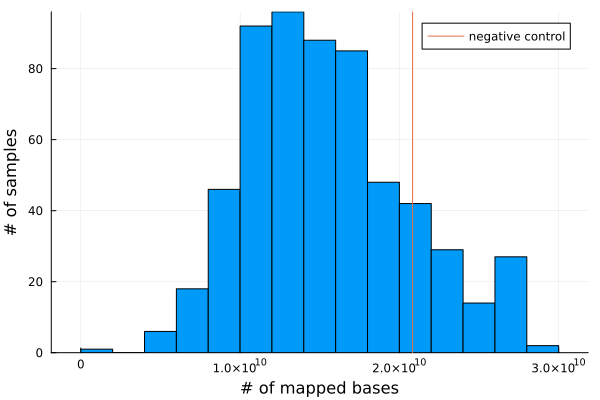

In [74]:
mean_mapped_bases = Statistics.mean(sample_summary_table[!, "total_mapped_bases"])
std_mapped_bases = Statistics.std(sample_summary_table[!, "total_mapped_bases"])

p = StatsPlots.histogram(
    sample_summary_table[!, "total_mapped_bases"],
    ylabel = "# of samples",
    xlabel = "# of mapped bases",
    label=""
)
# p = StatsPlots.vline!(
#     [mean_mapped_bases - 2.5std_mapped_bases],
#     label="-2.5 standard deviations"
# )

p = StatsPlots.vline!(
        [sample_summary_table[findfirst(sample_summary_table[!, "sample_id"] .== "SRR6399584"), "total_mapped_bases"]],
        label="negative control"
    )

In [ ]:
# first list

# 1	SRR6399584	chaoexpo26_I6
# 2	SRR6399726	chaoexpo62_I6
# 3	SRR6399596	chaoexpo36_I15
# 4	SRR7365476	chaoexpo27_I5
# 5	SRR6399525	chaoexpo67_I12
# 6	SRR6399862	chaoexpo17_I15
# 7	SRR6399652	xinexpo76_I5

In [80]:
sort!(sample_summary_table, "percent_mapped_bases_viral", rev=true)[1:10, :]

Row,sample_id,total_mapped_bases,total_contigs,total_assembly_size,percent_contigs_viral,percent_mapped_bases_viral
,String,Int64,Int64,Int64,Float64,Float64
1,SRR7365468,6080239502,2794,1518767,7.695,58.8741
2,SRR6399623,9640341032,11671,10777302,2.562,38.0192
3,SRR7365469,7342715424,15088,16836017,1.306,31.075
4,SRR6399775,12484379397,13214,11933173,4.533,27.6153
5,SRR6399922,12873397610,9781,12088982,3.139,24.3767
6,SRR6399586,10335671529,18706,18645284,2.812,22.4067
7,SRR6399876,15827208316,41567,47369804,1.174,22.02
8,SRR6399929,14638831124,13225,10185922,5.444,21.2176
9,SRR6399668,11422008610,11418,14556753,1.147,20.858


In [98]:
a = sort(sample_summary_table, "total_mapped_bases_viral", rev=true)[1:10, "sample_id"]
b = sort(sample_summary_table, "percent_mapped_bases_viral", rev=true)[1:10, "sample_id"]
ab = union(a, b)
# for x in union(a, b)
#     println(x)
# end

13-element Vector{String}:
 "SRR6399623"
 "SRR7365468"
 "SRR6399876"
 "SRR6399775"
 "SRR6399584"
 "SRR6399922"
 "SRR6399929"
 "SRR6399878"
 "SRR6399505"
 "SRR6399872"
 "SRR7365469"
 "SRR6399586"
 "SRR6399668"

In [112]:
# sample_summary_table[, "total_mapped_bases"] .>= contamination_load
# sample_summary_table[



2-element Vector{String}:
 "SRR6399584"
 "SRR6399878"

In [107]:
metadata_file = joinpath(dirname(pwd()), "metadata", "exposome", "SraRunInfo.csv")
metadata_table = DataFrames.DataFrame(uCSV.read(metadata_file, header=1)...)

Row,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,Experiment,LibraryName,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,InsertSize,InsertDev,Platform,Model,SRAStudy,BioProject,Study_Pubmed_id,ProjectID,Sample,BioSample,SampleType,TaxID,ScientificName,SampleName,g1k_pop_code,source,g1k_analysis_group,Subject_ID,Sex,Disease,Tumor,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash
,String,String,String,Int64,Int64,Int64,Int64,Int64,String,String,String,String,String,String,String,String,Int64,Int64,String,String,String,String,String,Int64,String,String,String,Int64,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String,String
1,SRR6399989,2018-09-20 00:09:46,2017-12-21 02:43:46,69707244,20779491232,69707244,298,8471,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399989.sralite.1,SRX3493025,chaoexpo01_I12,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS2776627,SAMN08215723,simple,655179,air metagenome,chaoexpo01_I12,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,AE2671898D257022D2D7FCE54762110F,4A3D148776DFCE8DDFD73EC823C417B0
2,SRR6399861,2018-09-20 00:09:49,2017-12-21 01:31:21,74776004,22149677110,74776004,296,8951,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399861.sralite.1,SRX3493153,chaoexpo01_I15,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS2776755,SAMN08215733,simple,655179,air metagenome,chaoexpo01_I15,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,1F1D03A3D0446A9A0C1F579B05593887,F7B99D3DF79CA3B879C6AB1B5FAC27CC
3,SRR7365467,2018-09-20 00:09:52,2018-06-19 14:27:01,42394156,12547372884,42394156,295,3018,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos3/sra-pub-zq-22/SRR007/365/SRR7365467.sralite.1,SRX4238427,chaoexpo01_I5,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS3435436,SAMN09454482,simple,655179,air metagenome,chaoexpo01_I5,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA724669,,public,0EB042A2417A66D7D4386E13ECE7C227,E593D63B10EE4CBADB7910CEFC967F4F
4,SRR6399751,2018-09-20 00:09:38,2017-12-20 23:26:18,83744386,24850346547,83744386,296,9109,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399751.sralite.1,SRX3492696,chaoexpo01_I6,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS2776300,SAMN08215708,simple,655179,air metagenome,chaoexpo01_I6,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,04B4DC260E73372B658D9349DBA04FAA,D8F94567AE16B04E9690964A8E35C1E9
5,SRR6399787,2018-09-20 00:09:37,2017-12-20 23:57:04,66107363,19225536114,66107363,290,5314,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/399/SRR6399787.sralite.1,SRX3492660,chaoexpo02_I12,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS2776259,SAMN08215800,simple,655179,air metagenome,chaoexpo02_I12,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,6A92652D5CEA5658FD9EB02CDA8937BE,E5F59997E6FD19E844D33D5BC2B0D002
6,SRR6400016,2018-09-20 00:09:46,2017-12-21 03:10:46,62527744,18527290879,62527744,296,5642,GCA_000001405.13,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos5/sra-pub-zq-14/SRR006/400/SRR6400016.sralite.1,SRX3492998,chaoexpo02_I15,WGS,MDA,METAGENOMIC,PAIRED,0,0,ILLUMINA,Illumina HiSeq 4000,SRP127288,PRJNA421162,,421162,SRS2776599,SAMN08215815,simple,655179,air metagenome,chaoexpo02_I15,,,,,,,no,,,,,STANFORD UNIVERSITY,SRA640713,,public,F4ECBE94C10E8FAAAA42B6FA0EA19A08,EAAB4E2C2F14F9E8174BF4BDDAA61059
7,SRR6399489,2018-09-20 00:09:45,2017-12-22 23:21:34,86508964,25502129583,86508964,294,6495,GCA_000001405.13,https://sra-do

In [110]:
for x in metadata_table[map(x -> x in ab, metadata_table[!, "Run"]), "LibraryName"]
    println(x)
end

chaoexpo13_I5
chaoexpo14_I12
chaoexpo14_I5
chaoexpo15_I5
chaoexpo16_I12
chaoexpo16_I5
chaoexpo16_I6
chaoexpo18_I12
chaoexpo18_I15
chaoexpo18_I5
chaoexpo18_I6
chaoexpo19_I6
chaoexpo26_I6


In [113]:
is_in_top_set = map(x -> x in ab, sample_summary_table[!, "sample_id"])
is_above_contamination_load = sample_summary_table[!, "total_mapped_bases"] .>= contamination_load
above_contamination = sample_summary_table[is_in_top_set .& is_above_contamination_load, "sample_id"]

2-element Vector{String}:
 "SRR6399584"
 "SRR6399878"

In [114]:
for x in metadata_table[map(x -> x in above_contamination, metadata_table[!, "Run"]), "LibraryName"]
    println(x)
end

chaoexpo14_I5
chaoexpo26_I6


In [ ]:


# joint_summary_table = DataFrames.innerjoin(summary_table, metadata_table, on="sample_identifier" => "Run")

In [ ]:
# intersect list above with library prep dataframe

In [91]:
# sample_summary_table[!, "total_mapped_bases_viral"] = sample_summary_table[!, "total_mapped_bases"] .* sample_summary_table[!, "percent_mapped_bases_viral"]

In [92]:
# findfirst(sample_summary_table[!, "sample_id"] .== "SRR6399584") / DataFrames.nrow(sample_summary_table)

In [93]:
# negative_control = sample_summary_table[findfirst(sample_summary_table[!, "sample_id"] .== "SRR6399584"), "total_mapped_bases"]

In [94]:
# negative_control = 6080239502

In [95]:
# sample_summary_table[sample_summary_table[!, "total_mapped_bases"] .<= (mean_mapped_bases - 2std_mapped_bases), :]

In [96]:
# sample_summary_table[sample_summary_table[!, "total_mapped_bases"] .>= (mean_mapped_bases - 2.5std_mapped_bases), :]

20828474377

In [97]:
# sort(sample_summary_table, "percent_contigs_viral", rev=true)

In [ ]:
# DataFrames.groupby(sort!(joint_contig_info_table[.!isempty.(joint_contig_info_table[!, "subject id"]), :], "evalue"), "Method")

In [ ]:
# DataFrames.sort!(DataFrames.groupby(joint_contig_info_table, "Method"), "")

In [ ]:
# take genomad and virsorter results as binary

In [ ]:
# make 

In [ ]:
# tophit_report = "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy/final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.UniRef100_tophit_report"
# Mycelia.parse_mmseqs_easy_taxonomy_tophit_report(tophit_report)

In [ ]:
# tophit_aln = "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy/final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.UniRef100_tophit_aln"
# Mycelia.parse_mmseqs_tophit_aln(tophit_aln)

In [ ]:
# report - this is tree-based relative frequencies - make krona plots from these!

In [ ]:
# load in other classification approaches

In [ ]:
# get number of contigs from each sample

In [ ]:
# viral_frequency_table = DataFrames.DataFrame(
#     sample_identifier = String[],
#     classification_method = String[],
#     percent_viral_contigs = Float64[]
# )

# ProgressMeter.@showprogress for SRR_path in SRR_paths
#     mmseqs_dir = joinpath(SRR_path, "mmseqs_easy_taxonomy")
#     for db in uniref_dbs
#         kraken_report = "$(mmseqs_dir)/final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.$(db)_report"
#         # add something to determine everything below viruses with phylokit or whatever it's called
#         viral_lines = collect(Iterators.filter(x -> occursin(r"virus"i, x) && occursin(r"10239"i, x), eachline(kraken_report)))
#         if length(viral_lines) == 0
#             percent_viral_contigs = 0.0
#         elseif length(viral_lines) == 1
#             viral_line_table = Mycelia.read_kraken_report(IOBuffer(join(viral_lines, '\n')))
#             percent_viral_contigs = viral_line_table[1, "percentage_of_fragments_at_or_below_taxon"]
#         else
#             display(viral_lines)
#             error()
#         end
#         row = (
#             sample_identifier = basename(SRR_path),
#             classification_method = db,
#             percent_viral_contigs = percent_viral_contigs
#         )
#         push!(viral_frequency_table, row)
#     end
# end
# viral_frequency_table

In [ ]:
# readdir()

In [ ]:
# summary_table = DataFrames.combine(DataFrames.groupby(viral_frequency_table, "sample_identifier"), "percent_viral_contigs" => Statistics.median)
# metadata_file = joinpath(dirname(pwd()), "metadata", "exposome", "SraRunInfo.csv")
# metadata_table = DataFrames.DataFrame(uCSV.read(metadata_file, header=1)...)
# joint_summary_table = DataFrames.innerjoin(summary_table, metadata_table, on="sample_identifier" => "Run")
# joint_summary_table = sort(joint_summary_file, "percent_viral_contigs_median", rev=true)

In [ ]:
# joint_summary_table[joint_summary_table[!, "percent_viral_contigs_median"] .>= 1, ["sample_identifier", "LibraryName"]]

In [ ]:
# SRR_path = first(SRR_paths)

In [ ]:
# make joint_contig_info reports

In [ ]:
# readdir(SRR_path)

In [ ]:
# # "genomad"
# readdir(joinpath(SRR_path, "genomad", "final.contigs.fastg.gfa_summary"))
# # "final.contigs.fastg.gfa_virus_genes.tsv"
# # "final.contigs.fastg.gfa_virus_proteins.faa"

# # "final.contigs.fastg.gfa_virus.fna"
# # "final.contigs.fastg.gfa_virus_summary.tsv"

In [ ]:
# hit vs no hit
# "blastn"

In [ ]:
# "virsorter"
# # final-viral-score.tsv - 1 line per viral contig
# # final-viral-combined.fa - viral fasta records

In [ ]:
# readdir(SRR_path)

In [ ]:
# summary_table = DataFrames.combine(DataFrames.groupby(viral_frequency_table, "sample_identifier"), "percent_viral_contigs" => Statistics.median)

In [ ]:

# for SRR_path in SRR_paths
#     SRR = basename(SRR_path)
#     assembled_fasta = joinpath(SRR_path, "megahit", "final.contigs.fastg.gfa.fna")
#     out_dir = mkpath(joinpath(SRR_path, "mmseqs_easy_taxonomy"))
#     outfile_base = joinpath(out_dir, basename(assembled_fasta) * ".mmseqs_easy_taxonomy." * basename(target_database))
#     outfiles = [outfile_base * ext for ext in ["_lca.tsv", "_report", "_tophit_aln", "_tophit_report"]]
#     if !all(isfile, outfiles)
#         println("need to run $target_database for $SRR")
#         # run(`sbatch mmseqs.sh $(assembled_fasta) $(target_database) $(outfile_base) $(joinpath(out_dir, "tmp"))`)
#         # println(`sbatch mmseqs.sh $(assembled_fasta) $(target_database) $(outfile_base) $(joinpath(out_dir, "tmp"))`)
#         # 73 minutes UniRef100
#         # 35 minutes UniRef90
#         # 10 minutes UniRef50
#         # println("conda run --no-capture-output -n mmseqs2 mmseqs easy-taxonomy $(assembled_fasta) $(target_database) $(outfile_base) $(joinpath(out_dir, "tmp"))")
#         # Mycelia.run_mmseqs_easy_taxonomy(out_dir=SRR_path, query_fasta=assembled_fasta, target_database=target_database, outfile=SRR)
#     else
#         println("all outfiles already exists for $target_database and $SRR...")
#     end
# end

In [ ]:
# python $HOME/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/kreport2krona.py -r $HOME/workspace/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy_default/SRR6399459.mmseqs_easy_taxonomy.UniRef100.txt_report -o $HOME/workspace/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy_default/SRR6399459.mmseqs_easy_taxonomy.UniRef100.txt_report.krona
# mamba install -c bioconda krona
# ktUpdateTaxonomy.sh
# ktImportText $HOME/workspace/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy_default/SRR6399459.mmseqs_easy_taxonomy.UniRef100.txt_report.krona -o $HOME/workspace/Mycelia/projects/viral-pangenome-discovery/data/SRA/SRR6399459/mmseqs_easy_taxonomy_default/SRR6399459.mmseqs_easy_taxonomy.UniRef100.txt_report.krona.html
# if !isfile(krona_file)
#     run(`python kreport2krona.py -r $(report) -o $(krona_file)`)
# end
# if !isfile(krona_html)
#     run(`ktImportText $(krona_file) -o $(krona_html)`)
# end